# Introduction

In a [previous post](//ccom.uprrp.edu/~humberto/very-small-rsa-example.html) we did a very small example of RSA, following [the tutorial by Barry Steyn](http://doctrina.org/How-RSA-Works-With-Examples.html). For working with modular integer arithmetic we used functions from a [toy RSA implementation by Alex Roper](https://github.com/calmofthestorm/toys/blob/master/rsa/rsa.py).

That toy implementation has functions for doing plain old RSA with larger keys, and support for encoding strings (and files, from the command line). We're going to use them today to encrypt and sign simple messages.

# Generating keys

With the rsa module, we can generate keys of a specified number of bits. Keys smaller than 2048 bits are not considered secure, but for this example we'll use smaller keys to speed up key generation.

In [1]:
import rsa

foo = rsa.RSAPrivateKey(128)

Even with the reduced key size we specified, the public modulus is a very large number.

In [2]:
foo.N

56252975735703161434548472734273948764393204385113622892228382201202846570577L

# Factoring

Factoring this would require serious resources. Factorizing with the sieve of erathostenes. See stack overflow.


In [3]:
import primefac
import timeit

Let's make some primes and factor them.

In [7]:
keysizes = range(8, 73, 8)

In [4]:
for bits in keysizes:
    foo = rsa.RSAPrivateKey(bits)
    print bits, foo.N
    %timeit -n 1 -r 1 list(primefac.primefac(foo.N))

8 19519
1 loops, best of 1: 829 µs per loop
16 3875929693
1 loops, best of 1: 2.51 ms per loop
24 269203889884381
1 loops, best of 1: 50.2 ms per loop
32 13499691401507401919
1 loops, best of 1: 1.01 s per loop
40 787210078486310632890791
1 loops, best of 1: 1.79 s per loop
48 71548955882825352262107560869
1 loops, best of 1: 3.35 s per loop
56 3980831609147300803826311416777347
1 loops, best of 1: 9.64 s per loop
64 205100251159123499184023049170761977913
1 loops, best of 1: 35.5 s per loop
72 16205768973557538892446950535225794171469113
1 loops, best of 1: 2min per loop


In [5]:
times = [829e-4, 2.51e-3, 50.2e-3, 1.01, 1.79, 3.35, 9.64, 35.5, 120]

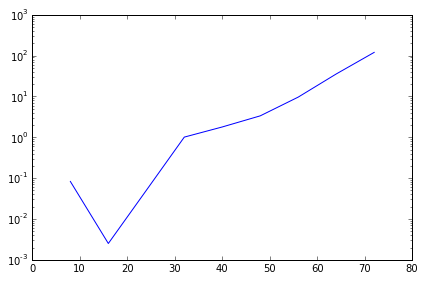

In [8]:
%matplotlib inline
import matplotlib, numpy
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot(keysizes, times)
plt.yscale('log')
fig.tight_layout()


In [9]:
foo.N

16205768973557538892446950535225794171469113L

As before, the public key is (e, N) and the private key is (d, N).

In [10]:
foo.e

5

In [11]:
foo.d

9723461384134523335463328237016439063994761L

I modified rsa.py to store p, q, and phi(n), so I can dig around the internals of RSA.

In [12]:
foo.phi

16205768973557538892438880395027398439991268L

We can quickly verify that e and d are multiplicative inverses in the integers modulo phi(n).

In [13]:
(foo.e * foo.d) % foo.phi

1L

# Encryption

If foo wants to send an encrypted message to bar, he will need bar's public key.

In [14]:
bar = rsa.RSAPrivateKey(128)
barpub = bar.GetPublicKey()

We will prepare a message to send to bar.

In [15]:
m = "Attack at dawn. This is a really long message to see if I can get rsa \
to encode it as more than one number."

Recall from last post that we can only encode numbers smaller than n. If we wish to send a longer message, we need to divide it into smaller pieces and send a sequence. For this we need to know bar's public modulus.

In [16]:
encoded = rsa.Message.Encode(m, barpub.N)
encoded.numbers

[115648799396826751567766945599864979770100194381312838842529118569426414700L,
 214012274130603322894259128424238691739369727293888509978752859858830192160L,
 182685454824088443191059084189136997345550917941544886668325422864334353512L,
 172144231835021845661017141195722362689495106685351054972168510011550466048L]

Now we are ready to compute the cyphertext. This transforms the encoded message into a cyphertext that only bar's private key can decrypt.

In [17]:
c = barpub.Encrypt(encoded)

In [18]:
c.numbers

[17998428231584194396443790128745022025729942632212773896140910914605942277934L,
 8384498851628060541375388361818805427685374148392909639965406090168376824019L,
 21380299388742044677091813594783678262821482897317773666993445225688729810227L,
 18576396343400687604287939910795888807723945946745299732042244520293850523927L]

In [19]:
bar.Decrypt(c).Decode()

'Attack at dawn. This is a really long message to see if I can get rsa to encode it as more than one number.'

# Signatures

A digital signature is just a message that has been encrypted with someone's private key. Thus anyone with the public key can verify that the message comes from the owner of the private key, and that no one has altered the message. 

In [20]:
reply = "This is really bar."
encoded_reply = rsa.Message.Encode(reply, bar.N)
encoded_reply.numbers

[149135777980097582635656205376687025111355119538120755623372731861778300928L]

We have to compute the signature manually, as the rsa module won't let us do it directly.

In [21]:
s = rsa.modexp(encoded_reply.numbers[0], bar.d, bar.N)

In [22]:
s

26658568300975919559709609495994150946249687264321412207473339735542374343994L

If foo receives a message claiming to come from bar, he can use bar's public key to confirm.

In [23]:
verify = encoded_reply
verify.numbers = [rsa.modexp(s, barpub.e, barpub.N)]

In [24]:
plaintext = rsa.Message.Decode(verify)
plaintext

'This is really bar.'

In [25]:
plaintext == reply

True